
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい


In [52]:
import pandas as pd
import numpy as np

#データの読み込み
age = pd.read_csv('Data/h27_age_df.csv')
family = pd.read_csv('Data/h27_family_df.csv')
gender = pd.read_csv('Data/h27_gender_df2.csv')
house = pd.read_csv('Data/h27_house_df.csv')
house_info = pd.read_csv('Data/h27_house_info_df.csv')
industry = pd.read_csv('Data/h27_indusry_df.csv')
job = pd.read_csv('Data/h27_job_df.csv')
labor = pd.read_csv('Data/h27_labor_df.csv')
marriage = pd.read_csv('Data/h27_marriage_df.csv')
work_status = pd.read_csv('Data/h27_work_status_df.csv')
income = pd.read_csv('Data/income_district.csv')

c:\Users\YuYaTano\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='income_mean', ylabel='Count'>

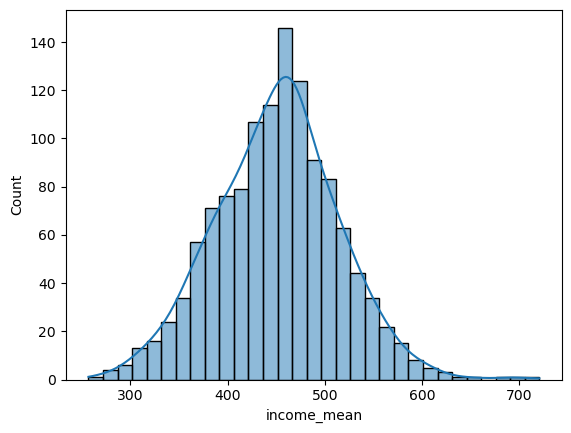

In [53]:
import seaborn as sns
sns.histplot(
	data = income,
	x='income_mean',
	kde=True,
	multiple='stack',)
#図から、収入の分布は正規分布に近似していると考えられる。

In [54]:
#教師あり機械学習で回帰分析を行う。
#データの特徴として、income_district.csvには、areaごとのデータが入っている。
#一方、国政調査のデータは更に細かく分かれているので、それらを整形してarea(district)ごとにまとめる。
#areaは、◯◯県◯◯市◯◯区のレベルである。
#以下、それぞれのデータを整形する。ただし、全ての変数を用いてしまうと多重共線性問題が発生する可能性がある。
# そこで、今回は代表として、age, family, industryを用いることにする。
#直感的な予想として、年齢が低い地域ほど働き手が多く収入が高い、家族が多い地域ほど収入が高い（消費も多くなると考えられるため）、産業が金融などサービス部門に偏っている地域ほど収入が高いだろう。

In [55]:
age1 = age[age['district2_id'].isna()]
age2 = age1.drop(columns=['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
age3 = age2.iloc[:, 0:20]
age4 = age3.replace('-', np.nan, inplace=False)
age5 = age4.astype(float)

In [79]:
labor11= labor[labor["district2_id"].isna()]
labor1= labor11.drop(columns=["district2_id","level_identifier","state_name","city_name","district_name","district2_name"])
labor1.head()

,district_id,labor_male,no_labor_male,labor_female,no_labor_female
0,23101,45761,15806,33891,32964
429,23102,21403,6637,17626,14209
542,23103,44853,17606,34961,33698
945,23104,43786,14240,32761,27786
1172,23105,38918,14117,29065,24806


In [56]:
family1 = family[family['district2_id'].isna()]
family2 = family1.drop(columns=['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
family3 = family2.iloc[:, 0:3]
family3.head()
family4 = family3.replace('-', np.nan, inplace=False)
family5 = family4.astype(float)
family5

,district_id,family_count,family_member_count
0,25201.0,136153.0,340973.0
593,25202.0,45546.0,113679.0
998,25203.0,41788.0,118193.0
1320,25204.0,29784.0,81312.0
1512,25206.0,60224.0,137247.0
...,...,...,...
250929,5366.0,1563.0,4986.0
250996,5368.0,796.0,3110.0
251024,5434.0,6152.0,20279.0
251195,5463.0,4807.0,15319.0


c:\Users\YuYaTano\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='family_count', ylabel='Count'>

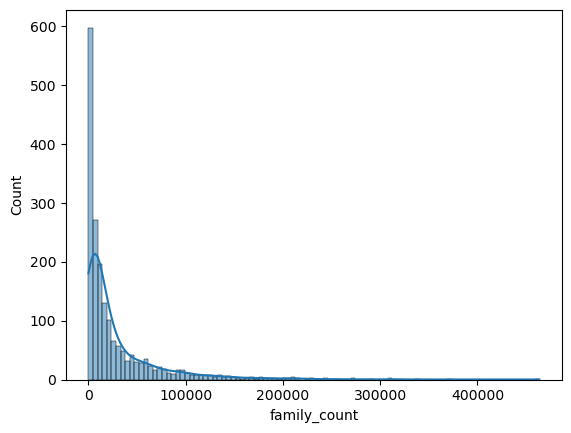

In [57]:
import seaborn as sns
#from sklearn.impute import SimpleImputer
import matplotlib as plt
sns.histplot(
	data=family5,
	x='family_count',
	kde=True,
	multiple='stack')
#pd.option_context('mode.use_inf_as_na', True)

c:\Users\YuYaTano\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='labor_male', ylabel='Count'>

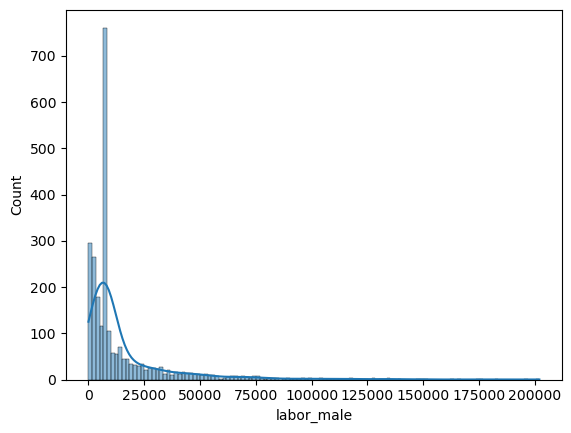

In [108]:
sns.histplot(
	data=merged2,
	x='labor_male',
	kde=True,
	multiple='dodge')

In [58]:
industry1 = industry[industry['district2_id'].isna()]
industry2 = industry1.drop(columns=['district2_id', 'level_identifier', 'state_name', 'city_name', 'district_name', 'district2_name'])
industry3 = industry2.replace('-', np.nan, inplace=False)
industry3 = industry3.astype(float)
#合算する（男性と女性）
#結合する：miningとかは結構細かいので、6個くらい？にまとめる
#男女で40こずつの計80個

c:\Users\YuYaTano\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='A_agriculture_forestry_male', ylabel='Count'>

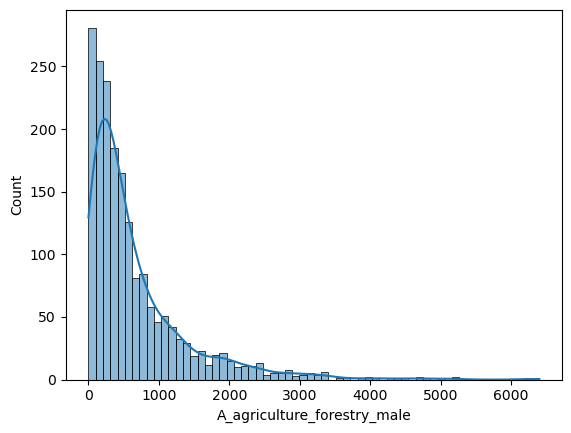

In [59]:
sns.histplot(
	data=industry3,
	x='A_agriculture_forestry_male',
	kde=True,
	multiple='stack')

In [60]:
merged1 = pd.merge(income, family5, how='outer',
                  left_on='area_code', right_on='district_id')
merged1.head()

,area_code,income_mean,district_id,family_count,family_member_count
0,13228.0,480.984419,13228.0,30817.0,80954.0
1,43514.0,439.775281,43514.0,5298.0,15523.0
2,23237.0,487.507769,23237.0,33190.0,86898.0
3,18208.0,505.495103,18208.0,9697.0,28729.0
4,12238.0,385.423846,12238.0,14849.0,38594.0


In [86]:
from sklearn.impute import SimpleImputer

merged2 = pd.merge(merged1, labor1, how='outer',left_on='area_code', right_on='district_id')
merged2.replace('-', np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
merged2[["family_count","family_member_count","labor_male","no_labor_male","labor_female","no_labor_female","income_mean"]] = imputer.fit_transform(merged2[["family_count","family_member_count","labor_male","no_labor_male","labor_female","no_labor_female","income_mean"]])

In [85]:
merged2.head()

,area_code,income_mean,district_id_x,family_count,family_member_count,district_id_y,labor_male,no_labor_male,labor_female,no_labor_female
0,13228.0,480.984419,13228.0,30817.0,80954.0,13228.0,21157.0,9370.0,15070.0,16543.0
1,43514.0,439.775281,43514.0,5298.0,15523.0,43514.0,4120.0,1917.0,3939.0,3352.0
2,23237.0,487.507769,23237.0,33190.0,86898.0,23237.0,25057.0,9666.0,18479.0,17560.0
3,18208.0,505.495103,18208.0,9697.0,28729.0,18208.0,8415.0,3396.0,7306.0,6166.0
4,12238.0,385.423846,12238.0,14849.0,38594.0,12238.0,10210.0,6307.0,7823.0,10036.0


In [88]:
#スケーリング
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scatterd_family_count =  scaler.fit_transform(merged2[["family_count"]])
scatterd_family_member_count =  scaler.fit_transform(merged2[["family_member_count"]])
scatterd_labor_male =  scaler.fit_transform(merged2[["labor_male"]])
scatterd_labor_female =  scaler.fit_transform(merged2[["labor_female"]])
scatterd_income =  scaler.fit_transform(merged2[["income_mean"]])

#display(scatterd_family_count,scatterd_family_member_count,scatterd_labor_male,scatterd_labor_female,scatterd_income)

In [97]:
#merged3 = np.column_stack((scatterd_family_count, scatterd_family_member_count, scatterd_labor_male,scatterd_labor_female,scatterd_income))
merged3 = np.column_stack((scatterd_family_count, scatterd_labor_male,scatterd_income))
merged3

array([[0.06646665, 0.10466227, 0.48308801],
       [0.01142503, 0.02034948, 0.39423711],
       [0.07158495, 0.12396261, 0.49715299],
       ...,
       [0.02398459, 0.01305   , 0.42433769],
       [0.02398459, 0.00857133, 0.42433769],
       [0.02398459, 0.01116945, 0.42433769]])

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [99]:
# 特徴量とターゲットにデータを分ける
X = merged3[:, :2]  # 最初の2列を特徴量に
y = merged3[:, 2]   # 最後の1列をターゲットに

len(X) == len(y)

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

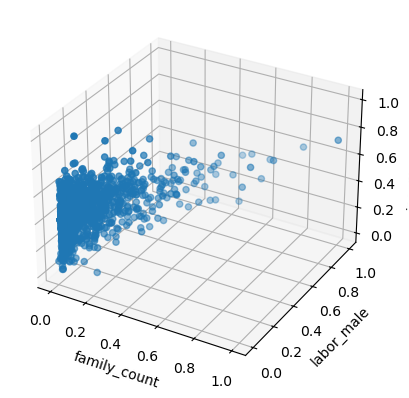

In [100]:
import matplotlib.pyplot as plt
# 3次元プロットを作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

family_count = merged3[:,0]
#family_member_count = merged3[:,1]
labor_male = merged3[:,1]
#labor_female = merged3[:,3]
income_mean =  merged3[:,2]
# 3D散布図を描画
ax.scatter(family_count,labor_male, income_mean)

# プロットのラベルを設定
ax.set_xlabel("family_count")
ax.set_ylabel("labor_male")
ax.set_zlabel("income_mean")

# プロットを表示
plt.show()

In [101]:
# モデルのインスタンスを作成
model = LinearRegression()
# モデルの訓練
model.fit(X_train, y_train)

LinearRegression()

In [102]:
from sklearn.metrics import r2_score
import statsmodels.api as sm
# テストデータで予測
y_pred = model.predict(X_test)

# モデルの性能を評価 (平均二乗誤差を使用)
mse = mean_squared_error(y_test, y_pred)
#r2_score = r2_score(y_test, y_pred)

#調整済み決定係数を求める
m = sm.OLS(y_train, sm.add_constant(X_train))
result = m.fit()

print("Mean Squared Error:", mse)
print("R^2 Score:", r2_score(y_test, y_pred))
print("Adjusted:", result.rsquared_adj)
#print("Predictions:", y_pred)

Mean Squared Error: 0.009369477324954826
R^2 Score: 0.05330690327086196
Adjusted: 0.06293741886621762


ここから下は下書き

In [61]:
#欠損値の処理
from sklearn.impute import SimpleImputer
#import numpy as np

# '-'をNaNに変換
merged1.replace('-', np.nan, inplace=True)

# SimpleImputerを使ってNaNを中央値で置き換え
imputer = SimpleImputer(strategy='median')
merged1[["family_count","family_member_count","income_mean"]] = imputer.fit_transform(merged1[["family_count","family_member_count","income_mean"]])

In [62]:
#スケーリング
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scatterd_family_count =  scaler.fit_transform(merged1[["family_count"]])
scatterd_family_member_count =  scaler.fit_transform(merged1[["family_member_count"]])
scatterd_income =  scaler.fit_transform(merged1[["income_mean"]])
display(scatterd_family_count,scatterd_family_member_count,scatterd_income)

array([[0.06646665],
       [0.01142503],
       [0.07158495],
       ...,
       [0.00336906],
       [0.00171473],
       [0.00174277]])

array([[0.08959758],
       [0.01716431],
       [0.09617769],
       ...,
       [0.00549966],
       [0.0034229 ],
       [0.00286939]])

array([[0.48308801],
       [0.39423711],
       [0.49715299],
       ...,
       [0.42433769],
       [0.42433769],
       [0.42433769]])

In [63]:
merged2 = np.column_stack((scatterd_family_count, scatterd_family_member_count, scatterd_income))
merged2

array([[0.06646665, 0.08959758, 0.48308801],
       [0.01142503, 0.01716431, 0.39423711],
       [0.07158495, 0.09617769, 0.49715299],
       ...,
       [0.00336906, 0.00549966, 0.42433769],
       [0.00171473, 0.0034229 , 0.42433769],
       [0.00174277, 0.00286939, 0.42433769]])

In [ ]:
# 特徴量とターゲットにデータを分ける
X = merged2[:, :2]  # 最初の2列を特徴量に
y = merged2[:, 2]   # 最後の1列をターゲットに

len(X) == len(y)

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

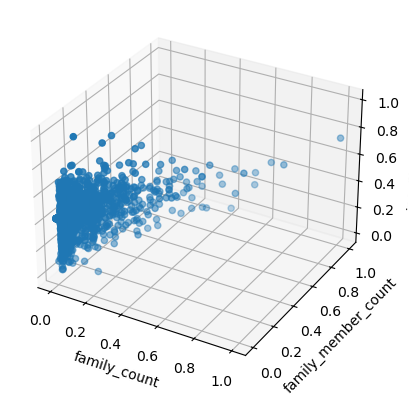

In [66]:
import matplotlib.pyplot as plt
# 3次元プロットを作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

family_count = merged2[:,0]
family_member_count = merged2[:,1]
income_mean =  merged2[:,2]
# 3D散布図を描画
ax.scatter(family_count,family_member_count, income_mean)

# プロットのラベルを設定
ax.set_xlabel("family_count")
ax.set_ylabel("family_member_count")
ax.set_zlabel("income_mean")

# プロットを表示
plt.show()

In [67]:
# モデルのインスタンスを作成
model = LinearRegression()
# モデルの訓練
model.fit(X_train, y_train)

LinearRegression()

In [77]:
from sklearn.metrics import r2_score
import statsmodels.api as sm
# テストデータで予測
y_pred = model.predict(X_test)

# モデルの性能を評価 (平均二乗誤差を使用)
mse = mean_squared_error(y_test, y_pred)
#r2_score = r2_score(y_test, y_pred)

#調整済み決定係数を求める
m = sm.OLS(y_train, sm.add_constant(X_train))
result = m.fit()

print("Mean Squared Error:", mse)
print("R^2 Score:", r2_score(y_test, y_pred))
print("Adjusted:", result.rsquared_adj)
#print("Predictions:", y_pred)

Mean Squared Error: 0.011926046227240278
R^2 Score: 0.012107801476566649
Adjusted: 0.05826884178908809


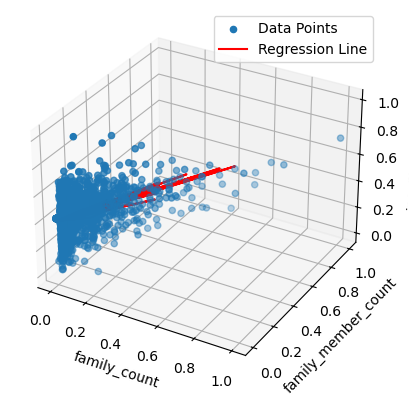

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3次元プロットを作成
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# データをプロット
ax.scatter(family_count, family_member_count, income_mean, label='Data Points')

# X_testとy_predが2次元の特徴量とそれに対応する予測値であることを仮定しています
# 例えば、X_testが (labor_male, labor_female) の2次元特徴量で、y_predがincome_meanの予測値の場合
ax.plot(X_test[:, 0], X_test[:, 1], y_pred, color='red', label='Regression Line')

# プロットのラベルを設定
ax.set_xlabel("family_count")
ax.set_ylabel("family_member_count")
ax.set_zlabel("income_mean")

# 凡例を追加
ax.legend()

# プロットを表示
plt.show()